# Adjoint plugin

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FAdjoint.ipynb).

In [1]:
from typing import List

import numpy as np
import jax.numpy as jnp
import matplotlib.pylab as plt
from jax import grad, value_and_grad

import sys; sys.path.append('../../../tidy3d')
import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.adjoint.components.simulation import JaxSimulation
from tidy3d.plugins.adjoint.components.geometry import JaxBox
from tidy3d.plugins.adjoint.components.medium import JaxMedium
from tidy3d.plugins.adjoint.components.structure import JaxStructure
from tidy3d.plugins.adjoint.components.data.sim_data import JaxSimulationData
from tidy3d.plugins.adjoint.web import run

INFO:rich:Using client version: 1.8.0


In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength

# resolution control
dl = 0.01

# space between boxes and PML
buffer = 1.5 * wavelength

# initial size of boxes and waveguide
lx0, ly0, lz0 = 1., 1., 0.5
wg_width = .7

# position of source and monitor (constant for all)
source_x = -lx0 - 1
meas_x = lx0 + 1

# total size
Lx = 2 * lx0 + 2 * buffer
Ly = 2 * ly0 + 2 * buffer
Lz = lz0 + 2 * buffer

# simulation parameters
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# permittivity at each quadrant of box
quadrants = [x + y for x in "+-" for y in "+-"]
permittivities = [2.0, 2.5, 3.0, 3.5]


wg_eps = 2.75

# frequency width and run time
freqw = freq0 / 10
run_time = 10 / freqw

# monitor for plotting
monitor_field = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="field_pattern",
)

size = np.array([lx0, ly0, lz0])

# adjoint parameters
subpixel = True
spacing = True
uniform_grid = True

if uniform_grid:
    grid_spec = td.GridSpec.uniform(dl=dl)
else:
    grid_spec = td.GridSpec.auto(wavelength=wavelength, min_steps_per_wvl=(wavelength/dl/np.sqrt(max(permittivities))))


In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz0)),
    medium=td.Medium(permittivity=wg_eps)
)

mode_size = (0,4,3)

# source seeding the simulation
forward_source = td.ModeSource(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0/10),
        center=[source_x, 0, 0],
        size=mode_size,
        mode_index=0,
        direction="+"
    )

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = 'measurement'

num_modes = 3

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    name=measurement_monitor_name,
)

In [4]:
def make_input_structures(*permittivities) -> List[JaxStructure]:

    eps_boxes = {quad: eps for (quad, eps) in zip(quadrants, permittivities)}
    boxes_quad = []
    for i, (quad, eps) in enumerate(eps_boxes.items()):

        x, y = quad
        xsign = 1 if x == "+" else -1
        ysign = 1 if y == "+" else -1

        spacing_factor = 1.2 if spacing else 1.0
        center_quad = [0, 0, 0]
        center_quad[0] += xsign * spacing_factor * lx0 / 2
        center_quad[1] += ysign * spacing_factor * ly0 / 2
        size_quad = size.tolist()

        box_quad = JaxStructure(
            geometry=JaxBox(center=center_quad, size=size_quad),
            medium=JaxMedium(permittivity=eps),
            name=quad,
        )
        boxes_quad.append(box_quad)
    return boxes_quad

In [5]:
def make_sim(*permittivities) -> JaxSimulation:
    """Make a simulation using a sequence of 4 permittivity values."""
    
    input_structures = make_input_structures(*permittivities)
    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=grid_spec,
        structures=[waveguide],
        input_structures=input_structures,
        sources=[forward_source],
        monitors=[],
        output_monitors=[measurement_monitor],
        run_time=run_time,
        subpixel=subpixel,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        shutoff=1e-8,
        courant=0.9,
    )

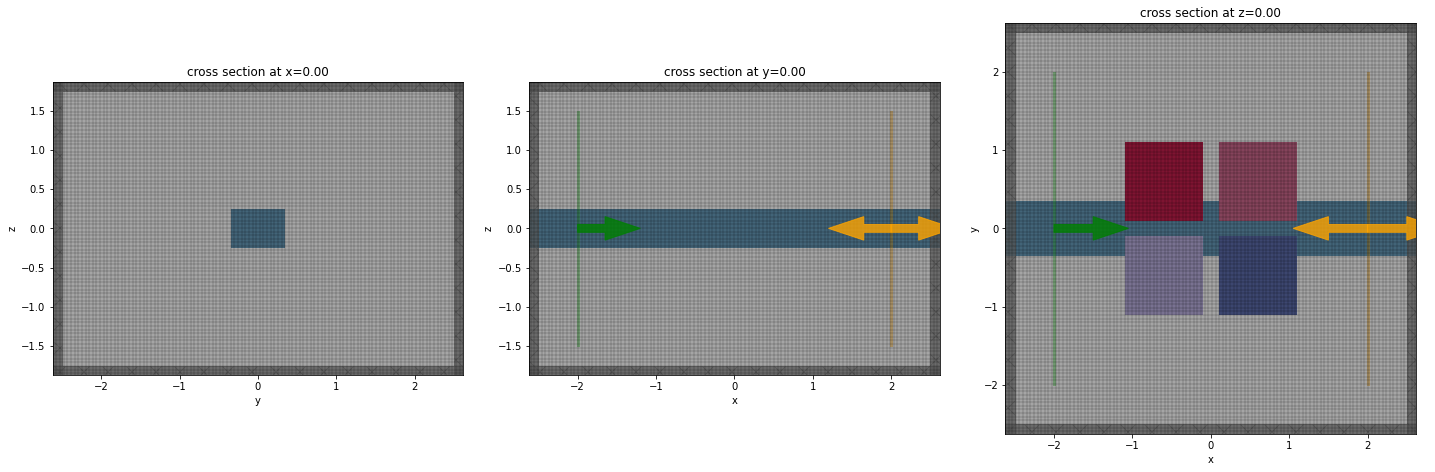

In [6]:
sim_base = make_sim(*permittivities)

f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(20, 10))

sim_plot = sim_base.to_simulation()[0]

for dim, ax in zip('xyz', axes):
    sim_plot.plot(**{dim:0}, ax=ax)
    sim_plot.plot_grid(**{dim:0}, ax=ax)

plt.show()

In [7]:
def measure_power(sim_data: JaxSimulationData) -> float:
    """Power in the 0th order mode."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=0)
    return jnp.sum(jnp.abs(amp)**2)

In [8]:
def J(*permittivities) -> float:
    """Objective function, construct simulation, run it using adjoint plugin, and return power in mode_index=0."""
    sim = make_sim(*permittivities)
    sim_data = run(sim, task_name="4_boxes")
    power_mode_0 = measure_power(sim_data)
    return power_mode_0

In [9]:
dJ_fn = grad(J, argnums=(0,1,2,3))

In [10]:
de1, de2, de3, de4 = grad_eps = dJ_fn(*permittivities)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 108.3/108.3 MB • 5.4 MB/s • 0:00:00

INFO:rich:loading SimulationData from simulation_data.hdf5


In [11]:
grad_eps = np.array(grad_eps)
grad_grad_eps_normalized = grad_eps / np.linalg.norm(grad_eps)
print(f"Jax gradient: {grad_grad_eps_normalized}")

Jax gradient: [ 0.6120488  -0.6203736   0.30847198 -0.38128465]


In [12]:
grad_jax = np.array(grad_eps).copy()

## Numerical Derivative

In [13]:
# grad_num = [0.24251638, -0.1488328, 0.2786219, -0.2516955]
grad_num = None

if not grad_num:
    # step size
    delta = 1e-2

    jax_sim_0 = make_sim(*permittivities)
    grid_spec0 = td.GridSpec(
        grid_x=td.CustomGrid(dl=jax_sim_0.grid.sizes.x), 
        grid_y=td.CustomGrid(dl=jax_sim_0.grid.sizes.y),
        grid_z=td.CustomGrid(dl=jax_sim_0.grid.sizes.z),
    )
    sims_batch_numerical = {}
    jax_info_dict = {}

    for i, eps_i in enumerate(permittivities):

        for sign in (+1, -1):
            input_structures_perturbed = list(jax_sim_0.input_structures)
            structure_i = input_structures_perturbed[i]
            deps = sign * delta
            new_medium = structure_i.medium.copy(update=dict(permittivity=structure_i.medium.permittivity + deps))
            new_structure = structure_i.copy(update=dict(medium=new_medium))
            input_structures_perturbed[i] = new_structure
            jax_sim_perturbed = jax_sim_0.copy(update=dict(input_structures=input_structures_perturbed))
            # jax_sim_perturbed = jax_sim_perturbed.copy(update=dict(grid_spec=grid_spec0))
            sim_perturbed, jax_info = jax_sim_perturbed.to_simulation()
            task_name = f'numerical_{i}_{sign}'
            sims_batch_numerical[task_name] = sim_perturbed
            jax_info_dict[task_name] = jax_info

    # run a batch of each of these 8 calculations at once
    batch_data = web.Batch(simulations=sims_batch_numerical).run(path_dir='data')

    # power_info[i] stores the [-, +] perturbations of permittivities[i]
    power_info = [[None, None] for _ in range(len(permittivities))]

    for task_name, sim_data_delta in batch_data.items():
        jax_info = jax_info_dict[task_name]
        jax_sim_data_delta = JaxSimulationData.from_sim_data(sim_data_delta, jax_info)

        # compute the objective function f(x)
        power = measure_power(jax_sim_data_delta)
        _, i, sign = task_name.split('_')
        sign_index = 0 if float(sign) < 0 else 1
        power_info[int(i)][sign_index] = power

    grad_num = []
    for power_minus, power_plus in power_info:
        grad_num.append((power_plus - power_minus) / 2 / delta)
    grad_num = np.array(grad_num)
    print('grad_num = [' + ', '.join([str(g) for g in grad_num]) + ']')

grad_num = np.array(grad_num)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0% • 0.0/29.6 kB • ? • -:--:--

INFO:rich:loading SimulationData from data/3cc05643-c0fa-4f75-a794-4aec0a104fe7.hdf5


grad_num = [0.20717084, -0.20991266, 0.10433346, -0.12918264]


In [14]:
rms_error = np.linalg.norm(grad_num - grad_jax) / np.linalg.norm(grad_num)

print('numerical (unnormalized): ', grad_num)
print('using jax (unnormalized): ', grad_jax)
print(f'norm(diff) / norm(numerical): {(rms_error * 100):.3f} %')

numerical (unnormalized):  [ 0.20717084 -0.20991266  0.10433346 -0.12918264]
using jax (unnormalized):  [ 0.2002505  -0.20297422  0.10092606 -0.12474895]
norm(diff) / norm(numerical): 3.334 %


In [15]:
grad_num_normalized = grad_num / np.linalg.norm(grad_num)
grad_jax_normalized = grad_jax / np.linalg.norm(grad_jax)
rms_error_normalized = np.linalg.norm(grad_num_normalized - grad_jax_normalized) / np.linalg.norm(grad_num_normalized)

print('numerical (normalized): ', grad_num_normalized)
print('using jax (normalized): ', grad_jax_normalized)
print(f'norm(diff) / norm(numerical): {(rms_error_normalized * 100):.3f} %')

numerical (normalized):  [ 0.61209434 -0.62019515  0.30825728 -0.38167515]
using jax (normalized):  [ 0.6120488  -0.6203736   0.30847198 -0.38128465]
norm(diff) / norm(numerical): 0.048 %


In [16]:
print(f'- dl={dl:.2f}: norm(diff) / norm(numerical): {(rms_error_normalized * 100):.3f} %')

- dl=0.01: norm(diff) / norm(numerical): 0.048 %


In [17]:
0.715

0.715